<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring Drop Spreading Law

University ID: 11018744<br>
University of Manchester  
February 2024

First initialise the Python interpreter.

In [3]:
# Initialisation
import string
import math
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

![](./img/bee.png)
## Experimental Data

This is the raw data. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [4]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

### Plotting raw data

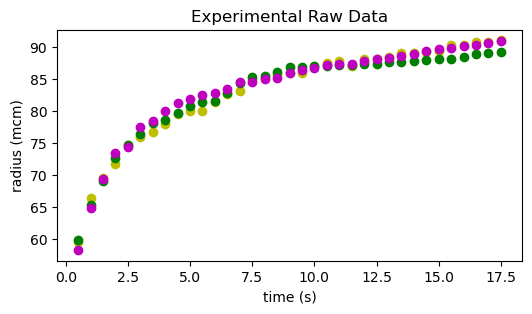

In [5]:
def initial_plot(time, radius_data1, radius_data2, radius_data3):
    # tweeking the figure size
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    # plotting data from experimental runs 1-3:
    plt.plot(time, radius_data1, "yo")
    plt.plot(time, radius_data2, "go")
    plt.plot(time, radius_data3, "mo")
    # setting axis labels & figures 
    plt.xlabel("time (s)")
    plt.ylabel("radius (mcm)")
    plt.title("Experimental Raw Data")
    # displaying the plot
    plt.show()
initial_plot(time, radius_data1, radius_data2, radius_data3)

### Finding Uncertainties

The standard deviation across the three values per time measurement is calculated and used as the uncertainty, and the mean values of the radius measurement at each time interval is also calculated to use in an initial plot of the experimental raw data with its uncertainties. 

In [6]:
def initial_uncertainties(radius_data1, radius_data2, radius_data3):
    all_data = np.vstack(((radius_data1, radius_data2, radius_data3)))
    std = np.std(all_data, axis = 0)
    means = np.mean(all_data, axis = 0)
    return std, means
STD, MEANS = initial_uncertainties(radius_data1, radius_data2, radius_data3)

### Plotting averaged raw data with uncertainties

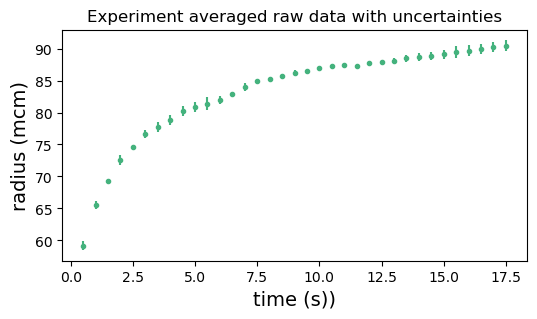

In [7]:
def initial_plot_avg_uncertainties(time, means, std):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.errorbar(time, means, yerr=std, fmt='.', c='#44B27D')

    ax.set_title('Experiment averaged raw data with uncertainties')
    ax.set_xlabel('time (s))',fontsize=14)
    ax.set_ylabel('radius (mcm)',fontsize=14)
    plt.show()
    plt.close()
initial_plot_avg_uncertainties(time, MEANS, STD)

Don't forget to find the errors on $R$ estimated from the three experimental runs.

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, i.e., express $U$ and $\theta$ using $R=R(t)$. 

The speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ is found.

In [8]:
V = 7.6
# coefficients of cubic eqn for height of the drop, H, (c is found later as depends on R) :
a = np.pi / 6
b = 0
d = (-V)

# finding speed of contact line, U
def speed_contact_line(time, radius_data1, radius_data2, radius_data3):
    SCL_array = np.zeros(34)
    for radius_data in(radius_data1, radius_data2, radius_data3):
        R_difference = radius_data[1:] - radius_data[:-1]
        delta_t = time[1:] - time[:-1]
        speed_contact_line = R_difference / delta_t
        SCL_array = np.vstack((SCL_array, speed_contact_line))
    SCL_array = SCL_array[1:,:]
    return SCL_array

# finding height of drop, H
def contact_angle(time, radius_data1, radius_data2, radius_data3):
    CA_array = np.zeros(35)
    for radius_data in(radius_data1, radius_data2, radius_data3):
        c = (np.pi / 2) * radius_data**2

        heights = []
        for i in c:
            coefficients = [a, b, i, d]
            roots = np.roots(coefficients)
            real_roots = roots[np.isreal(roots)].real
            heights = np.append(heights, real_roots)

    # finding contact angle, θ
        contact_angles = []
        for i in range(len(radius_data)):
            theta = (np.pi / 2) - np.arctan((radius_data[i]**2 - heights[i]**2)  / (2 * heights[i] * radius_data[i]))
            contact_angles = np.append(contact_angles, theta)
        CA_array = np.vstack((CA_array, contact_angles))
    CA_array = CA_array[1:, :]
    return CA_array

SPEED_CONTACT_LINE = speed_contact_line(time, radius_data1, radius_data2, radius_data3)
CONTACT_ANGLES = contact_angle(time, radius_data1, radius_data2, radius_data3)

### Uncertainties in speed contact line and contact angle

From the three arrays of speed of contact line and contact angle found (one for each data set), the means and standard deviation are calculated, with the standard deviations used as uncertainties.

In [9]:
# finding uncertainties in speed contact line & contact angle
def scl_ca_uncertainties(time, speed_contact_line, contact_angles):
    std_speed_contact_line = np.std(speed_contact_line, axis = 0)
    means_speed_contact_line = np.mean(speed_contact_line, axis = 0)

    std_contact_angle = np.std(contact_angles, axis = 0)
    means_contact_angle = np.mean(contact_angles, axis = 0)
    
    return std_speed_contact_line, means_speed_contact_line, std_contact_angle, means_contact_angle
(STD_SPEED_CONTACT_LINE, MEANS_SPEED_CONTACT_LINE, STD_CONTACT_ANGLE, MEANS_CONTACT_ANGLE) = \
                        scl_ca_uncertainties(time, SPEED_CONTACT_LINE, CONTACT_ANGLES)

### Plotting extracted quantities with uncertainties

From the graphs, both the speed of the contact line and the contact angle are seen to exponentially decay with time.

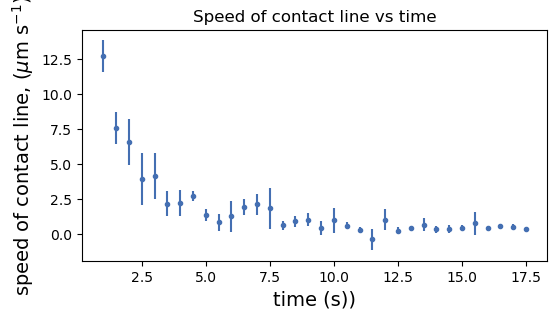

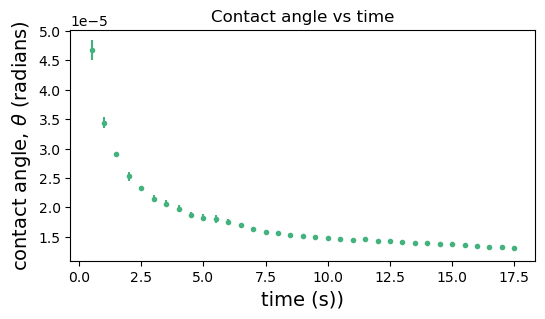

In [10]:
# plotting speed contact line vs time
def plot_SCL_and_CA_time(time, means_speed_contact_line, std_speed_contact_line, means_contact_angle, std_contact_angle):
    fig = plt.figure()
    ax_scl = fig.add_subplot(111)
    ax_scl.errorbar(time[1:], means_speed_contact_line, yerr=std_speed_contact_line, fmt='.', c='#446FB2')

    ax_scl.set_title('Speed of contact line vs time')
    ax_scl.set_xlabel('time (s))',fontsize=14)
    ax_scl.set_ylabel(r'speed of contact line, ($\mu$m s$^{-1}$)',fontsize=14)

    # plotting contact angles vs time
    fig = plt.figure()
    ax_ca = fig.add_subplot(111)
    ax_ca.errorbar(time, means_contact_angle, yerr=std_contact_angle, fmt='.', c='#44B27D')
    ax_ca.set_title('Contact angle vs time')
    ax_ca.set_xlabel('time (s))',fontsize=14)
    ax_ca.set_ylabel(r'contact angle, $\theta$ (radians)',fontsize=14)
    plt.show()
    plt.close()
plot_SCL_and_CA_time(time, MEANS_SPEED_CONTACT_LINE, STD_SPEED_CONTACT_LINE, MEANS_CONTACT_ANGLE, STD_CONTACT_ANGLE)

## Plotting contact line speed vs contact angles

The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

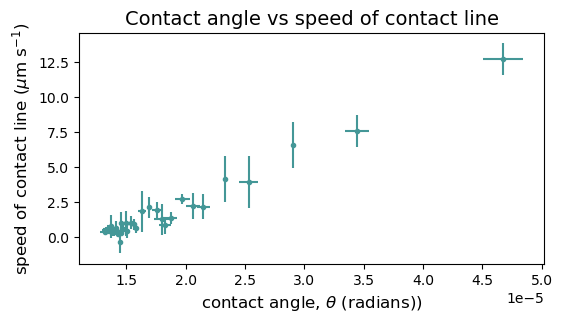

In [11]:
# plotting contact line speed vs contact angles
def plot_SCL_vs_CA(means_speed_contact_line, std_speed_contact_line, means_contact_angle, std_contact_angle):
    fig = plt.figure()
    ax_ca = fig.add_subplot(111)
    ax_ca.errorbar(means_contact_angle[:-1], means_speed_contact_line, xerr=std_contact_angle[:-1],\
               yerr= std_speed_contact_line, fmt='.', c='#449797')
    ax_ca.set_title('Contact angle vs speed of contact line',fontsize=14)
    ax_ca.set_xlabel(r'contact angle, $\theta$ (radians))',fontsize=12)
    ax_ca.set_ylabel(r'speed of contact line ($\mu$m s$^{-1}$)',fontsize=12)
    plt.show()
    plt.close()
plot_SCL_vs_CA(MEANS_SPEED_CONTACT_LINE, STD_SPEED_CONTACT_LINE, MEANS_CONTACT_ANGLE, STD_CONTACT_ANGLE)

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [12]:
def finding_U_fit(name, power, means_contact_angle, means_speed_contact_line):
    contact_angle_powered = np.power(means_contact_angle[:-1], power)

    (coef, covr) = np.polyfit(contact_angle_powered, means_speed_contact_line, 1, cov=True)
    
    # find the characteristic speed of the contact line, U_0, with uncertainty
    coef1 = coef[0]
    U_0 = coef1
    err_coef1 = np.sqrt(covr[0][0])
    err_U_0 = err_coef1
    
    # find the equilibrium contact angle, theta_0, depending on the model used, with uncertainty
    coef2 = coef[1]
    err_coef2 = np.sqrt(covr[1][1])

    if name == 'De Gennes Law':
        theta_0 = np.sqrt((-coef2) / U_0)
        err_theta_0 = theta_0 * np.sqrt(((-err_coef2) / (2 * coef2))**2 + ((-err_U_0) / (2 * U_0)**2))
    else:
        theta_0 = (-coef2 / U_0)**(1/3)
        err_theta_0 = (1/3) * np.sqrt( ((err_coef2**2) / ((coef2**2 * U_0)**(2/3))) + \
                                      (((coef2) / (U_0**4))**(2/3) * err_U_0**2 ) )

    # print statements for U_0 and theta_0
    print('For ', name,', characteristic speed of the contact line, U_0 = {:04.5e} +\- {:04.5e} μm/s per degree^{:}'.format(U_0, err_U_0, power))
    print('For ', name,', equilibrium contact angle, θ_0 = {:04.5e} +\- {:04.5e} degrees'.format(theta_0, err_theta_0))

    # calculate the fit line
    U_fit = np.polyval(coef, contact_angle_powered)
    return contact_angle_powered, U_fit

CONTACT_ANGLE_SQUARED, DG_U_FIT = finding_U_fit('De Gennes Law', 2, MEANS_CONTACT_ANGLE, MEANS_SPEED_CONTACT_LINE)
CONTACT_ANGLE_CUBED, CV_U_FIT = finding_U_fit('Cox-Voinov Law', 3, MEANS_CONTACT_ANGLE, MEANS_SPEED_CONTACT_LINE)

For  De Gennes Law , characteristic speed of the contact line, U_0 = 6.56667e+09 +\- 2.64072e+08 μm/s per degree^2
For  De Gennes Law , equilibrium contact angle, θ_0 = 9.61973e-06 +\- 1.11002e-06 degrees
For  Cox-Voinov Law , characteristic speed of the contact line, U_0 = 1.34321e+14 +\- 8.69113e+12 μm/s per degree^3
For  Cox-Voinov Law , equilibrium contact angle, θ_0 = 0nan +\- 1.64778e-06 degrees


/var/folders/y_/5rcm3p_s02n9b1lyrn3xl0t40000gn/T/ipykernel_29792/3908800583.py:20: RuntimeWarning: invalid value encountered in scalar power
  theta_0 = (-coef2 / U_0)**(1/3)


The characteristic speeds are large compared to values seen in the research paper by Kant et al. (2017), by several orders of magnitude. 

The Cox-Voinov model produces a '0nan' value for its equilibrium contact angle, which already suggests without looking at the residuals and chi-squared values that it is the least suitable model of the two. This is because the sign of the second coefficient, coef2, turns out positive, so program tries to square-root a negative number in the line,   

    theta_0 = (-coef2 / U_0)**(1/3) ,

which produces the error. This coef2 represents the y-intercept of the graphs, where it is expected to be negative such that the equilibrium contact angle is a positive value at $U = 0$, as it does not make physical sense to have a negative contact angle - which is defined as the angle between the tangent to the liquid-vapor interface and the solid surface at the point where the three phases (solid, liquid, and vapor) meet.

### Displaying the corresponding fits 

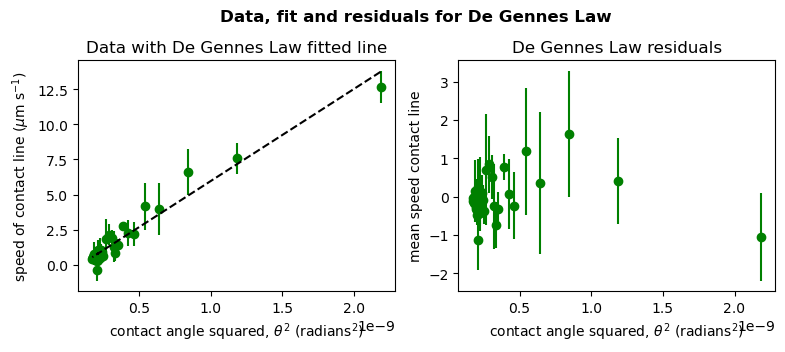

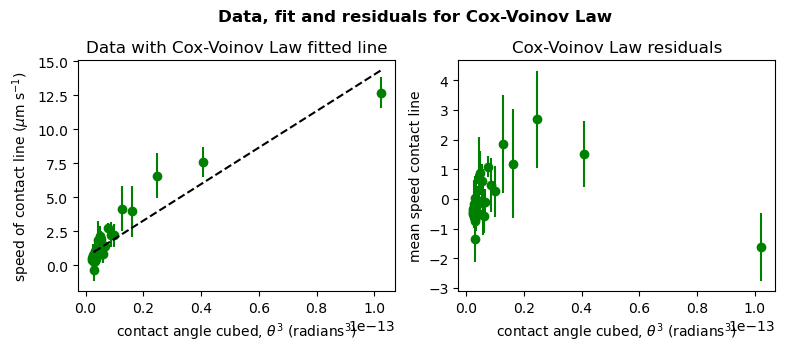

In [13]:
def plot_fit_functions(name, contact_angle_powered, means_speed_contact_line, std_speed_contact_line, U_fit):
    # Make plot of the residuals, using the 'errorbar' command 
    plt.rcParams['figure.figsize'] = (9,3)
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Data, fit and residuals for ' + name, y=1.05, fontweight='bold')

    # Plot the data with theta squared/cubed as the independent variable, with error bars
    ax1.errorbar(contact_angle_powered, means_speed_contact_line, yerr=std_speed_contact_line, fmt='og')
    if name == "De Gennes Law":
        ax1.set(xlabel=r"contact angle squared, $\theta^2$ (radians$^2$)")
    else:
        ax1.set(xlabel=r"contact angle cubed, $\theta^3$ (radians$^3$)")
    ax1.set(ylabel=r'speed of contact line ($\mu$m s$^{-1}$)')
    ax1.set_title('Data with ' + name + ' fitted line')

    # Add the fitted line
    ax1.errorbar(contact_angle_powered, U_fit, fmt='--k')

    # On the other plot, plot the residuals
    ax2.errorbar(contact_angle_powered, means_speed_contact_line - U_fit, yerr=std_speed_contact_line, fmt='og')
    if name == "De Gennes Law":
        ax2.set(xlabel=r"contact angle squared, $\theta^2$ (radians$^2$)")
    else:
        ax2.set(xlabel=r"contact angle cubed, $\theta^3$ (radians$^3$)")
    ax2.set(ylabel="mean speed contact line")
    ax2.set_title(name + ' residuals')
    plt.show()
    plt.close()

plot_fit_functions("De Gennes Law", CONTACT_ANGLE_SQUARED, MEANS_SPEED_CONTACT_LINE, STD_SPEED_CONTACT_LINE, DG_U_FIT)
plot_fit_functions("Cox-Voinov Law", CONTACT_ANGLE_CUBED, MEANS_SPEED_CONTACT_LINE, STD_SPEED_CONTACT_LINE, CV_U_FIT)

From these plots, the range of the contact angles seems to be on the order of $10^{-5}$, and approximately between $1\times 10^{-5}$ and $5\times 10^{-5}$ (calculating back from the extremes of the two graphs). This is very small, and  $≪90º$, implying that the liquid wets the surface and that the surface is strongly hydrophilic. 

![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. The chi-squared and reduced chi-squared values describe in a number that the residual plots depict. Where the data points of the De Gennes residual plot are no more than +/- 2 away from zero (with the original data set), the Cox-Voinov residual data points reach up to +2.5 away from zero, indicating a wider spread of data. This means the data does not fit the Cox-Voinov model as well as the De Gennes model.

The chi-squared values show this similarly by summing over the difference between the expected value from the model (at a particular x-value), and the measured value, and dividing by the uncertainty. This indicates how far off the measured data is from the model. The reduced chi-squared value is found by dividing the chi-squared value by the number of degrees of freedom which is the number of observations/ measurements minus the number of parameters - here the number of parameters is 2 because for a linear fit there are two variables. The closer the reduced chi-squared value is to 1, the better a model fits. 

In [14]:
# Calculate chi-squared value
def chi_squared(means_speed_contact_line, U_fit, std_speed_contact_line, contact_angle_powered):
    chi_squared = np.sum( ((means_speed_contact_line - U_fit) / (std_speed_contact_line))**2 )
    # Calculate number of degrees of freedom
    ndf = len(contact_angle_powered) - 2 # 2 fit parameters (linear fit)
    print('ndf = ',ndf)
    reduced_chi_squared = chi_squared/ndf
    return chi_squared, reduced_chi_squared
    
DG_CHI_SQUARED, DG_RED_CHI_SQUARED = chi_squared(MEANS_SPEED_CONTACT_LINE, DG_U_FIT, STD_SPEED_CONTACT_LINE, CONTACT_ANGLE_SQUARED)
print('De Gennes chi-squared value           X     = {:04.2f}'.format(DG_CHI_SQUARED))
print('De Gennes reduced chi-squared value   X_red = {:04.2f}'.format(DG_RED_CHI_SQUARED))
CV_CHI_SQUARED, CV_RED_CHI_SQUARED = chi_squared(MEANS_SPEED_CONTACT_LINE, CV_U_FIT, STD_SPEED_CONTACT_LINE, CONTACT_ANGLE_CUBED)
print('Cox-Voinov chi-squared value          X     = {:04.2f}'.format(CV_CHI_SQUARED))
print('Cox-Voinov reduced chi-squared value  X_red = {:04.2f}'.format(CV_RED_CHI_SQUARED))

ndf =  32
De Gennes chi-squared value           X     = 34.27
De Gennes reduced chi-squared value   X_red = 1.07
ndf =  32
Cox-Voinov chi-squared value          X     = 111.96
Cox-Voinov reduced chi-squared value  X_red = 3.50


![](./img/bee.png)
## Best Drop Spreading Law

The 'results()' function examines whether the two reduced chi-squared values lie in the accepted range of 0.8 - 1.5, and how they compare to each other, then prints a statement accordingly.

The results of the chi-squared analysis suggest that the De Gennes law is a better fit for the behaviour of the spreading drop because it has a reduced chi-squared value that sits in the range of 0.8 - 1.5.

In [15]:
def results(DG_red_chi_squared, CV_red_chi_squared):
    if 0.8 <= DG_red_chi_squared <= 1.5 and not 0.8 <= CV_red_chi_squared <= 1.5:
        print('The De Gennes Law fits better, because {0:04.2f} lies in the range of 0.8 - 1.5 whereas {1:04.2f} '
        'does not.'.format(DG_red_chi_squared, CV_red_chi_squared))
    elif 0.8 <= CV_red_chi_squared <= 1.5 and not 0.8 <= DG_red_chi_squared <= 1.5:
        print('The Cox-Voinov Law fits better, because {0:04.2f} lies in the range of 0.8 - 1.5 whereas {1:04.2f} '
        'does not.'.format(CV_red_chi_squared, DG_red_chi_squared))
    elif 0.8 <= DG_red_chi_squared <= 1.5 and 0.8 <= CV_red_chi_squared <= 1.5:
        if np.abs(DG_red_chi_squared - 1) < np.abs(CV_red_chi_squared - 1):
            print('Both the De Gennes and Cox-Voinov laws fit sufficiently well, however the De Gennes Law fits '
            'better because {0:04.2f} is closer to 1 than {1:04.2f}.'.format(DG_red_chi_squared, CV_red_chi_squared))
        if np.abs(DG_red_chi_squared - 1) > np.abs(CV_red_chi_squared - 1):
            print('Both the De Gennes and Cox-Voinov laws fit sufficiently well, however the Cox-Voinov Law fits '
            'better because {0:04.2f} is closer to 1 than {1:04.2f}.'.format(CV_red_chi_squared, DG_red_chi_squared))
    elif not (0.8 <= DG_red_chi_squared <= 1.5) and not (0.8 <= CV_red_chi_squared <= 1.5):
        if np.abs(DG_red_chi_squared - 1) < np.abs(CV_red_chi_squared - 1):
            print('Neither the De Gennes and Cox-Voinov laws fit sufficiently well, however the De Gennes Law fits '
            'better because {0:04.2f} is closer to 1 than {1:04.2f}.'.format(DG_red_chi_squared, CV_red_chi_squared))
        if np.abs(DG_red_chi_squared - 1) > np.abs(CV_red_chi_squared - 1):
            print('Neither the De Gennes and Cox-Voinov laws fit sufficiently well, however the Cox-Voinov Law fits '
            'better because {0:04.2f} is closer to 1 than {1:04.2f}.'.format(CV_red_chi_squared, DG_red_chi_squared))
results(DG_RED_CHI_SQUARED, CV_RED_CHI_SQUARED)

The De Gennes Law fits better, because 1.07 lies in the range of 0.8 - 1.5 whereas 3.50 does not.


![](./img/bee.png)
## Stretch yourself section

### Fitting data to alternative polynomial functions

Fitting data to $U(\theta) = A + B'\theta + U_0\theta^2$, and $U(\theta) = A + B'\theta +C'\theta^2 + U_0\theta^3$ and comparing the $U_0$ values to those obtained with the De Gennes and Cox-Voinov laws. 

In [16]:
def alternative_U_fit(name, power, means_contact_angle, means_speed_contact_line):
    contact_angle_powered = np.power(means_contact_angle[:-1], power)
    (coef, covr) = np.polyfit(contact_angle_powered, means_speed_contact_line, power, cov=True)
    
    # find the characteristic speed of the contact line, U_0, with uncertainty
    U_0 = coef[0]
    err_U_0 = np.sqrt(covr[0][0])
        
    # print statements for U_0 
    print('For ', name,', characteristic speed of the contact line, U_0 = {:04.5e} +\- {:04.5e}'.format(U_0, err_U_0))

    # calculate the fit line
    U_fit = np.polyval(coef, contact_angle_powered)
    
    return contact_angle_powered, U_fit

CONTACT_ANGLE_SQUARED, ALT_DG_U_FIT = alternative_U_fit('De Gennes Law', 2, MEANS_CONTACT_ANGLE, \
                                                              MEANS_SPEED_CONTACT_LINE)
CONTACT_ANGLE_CUBED, ALT_CV_U_FIT = alternative_U_fit('Cox-Voinov Law', 3, MEANS_CONTACT_ANGLE, \
                                                        MEANS_SPEED_CONTACT_LINE)

For  De Gennes Law , characteristic speed of the contact line, U_0 = -1.52095e+18 +\- 3.35891e+17
For  Cox-Voinov Law , characteristic speed of the contact line, U_0 = 3.59184e+40 +\- 1.12694e+40


### Plotting the alternative fit functions:

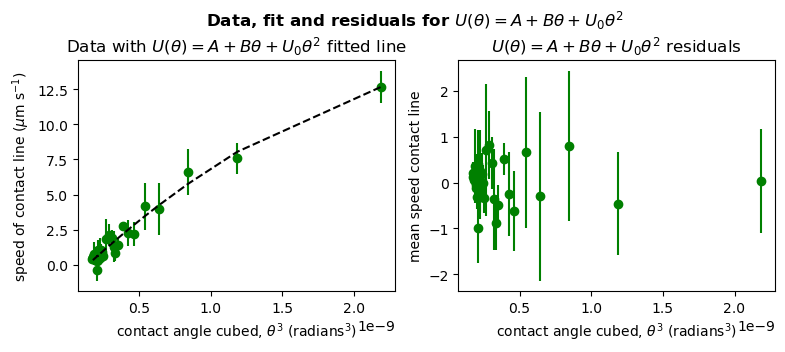

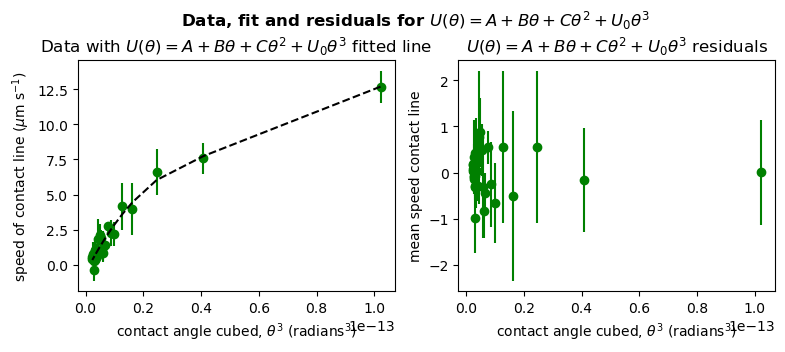

In [17]:
def alternative_plot_fit_functions(name, contact_angle_powered, means_speed_contact_line, std_speed_contact_line, U_fit):
    plt.rcParams['figure.figsize'] = (9,3)
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.suptitle(r'Data, fit and residuals for ' + name, y=1.05, fontweight='bold')

    # Plot the data with theta squared/cubed as the independent variable, with error bars
    ax1.errorbar(contact_angle_powered, means_speed_contact_line, yerr=std_speed_contact_line, fmt='og')
    if name == "De Gennes Law":
        ax1.set(xlabel=r"contact angle squared, $\theta^2$ (radians$^2$)")
    else:
        ax1.set(xlabel=r"contact angle cubed, $\theta^3$ (radians$^3$)")
    ax1.set(ylabel=r'speed of contact line ($\mu$m s$^{-1}$)')
    ax1.set_title(r'Data with ' + name + ' fitted line')

    # Add the fitted line
    ax1.errorbar(contact_angle_powered, U_fit, fmt='--k')
    
    # Residuals plot
    ax2.errorbar(contact_angle_powered, means_speed_contact_line - U_fit, yerr=std_speed_contact_line, fmt='og')
    if name == "De Gennes Law":
        ax2.set(xlabel=r"contact angle squared, $\theta^2$ (radians$^2$)")
    else:
        ax2.set(xlabel=r"contact angle cubed, $\theta^3$ (radians$^3$)")
    ax2.set(ylabel="mean speed contact line")
    ax2.set_title(name + ' residuals')
    plt.show()
    plt.close()

alt_fit_name1 = r"$U(\theta) = A + B \theta + U_0 \theta^2$"
alt_fit_name2 = r"$U(\theta) = A + B \theta + C \theta^2 + U_0\theta^3$"
alternative_plot_fit_functions(alt_fit_name1, CONTACT_ANGLE_SQUARED, MEANS_SPEED_CONTACT_LINE, \
                               STD_SPEED_CONTACT_LINE, ALT_DG_U_FIT)
alternative_plot_fit_functions(alt_fit_name2, CONTACT_ANGLE_CUBED, MEANS_SPEED_CONTACT_LINE, \
                               STD_SPEED_CONTACT_LINE, ALT_CV_U_FIT)

The values for $U_0$ differ by several orders of magnitude between this polynomial fit and the De Gennes / Cox-Voinov models. The quadratic/ cubic fits actually seem to produce a lower spread of results on the residuals plots, suggesting that they are better fits. This could be explained with analogy to Taylor series where polynomials are used to approximate other functions such as trigonometric functions, and the higher the order of the polynomials, the more accurate the approximation. Here, the quadratic and cubic models have higher order than the linear models used with the De Gennes and Cox-Voinov models.

However, they do not account for the equilibrium contact angle, and therefore the effects of hydrophobic a surface is when modelling the spreading law. The De Gennes Law also considers the capillary forces that arise from surface tension, and also the dissipation of energy due to viscous forces within the liquid. These aspects are not considered in a simple quadratic model and so the characteristic speed value will differ, in this case substantially. 

The Cox-Voinov model also takes into account contact angle dynamics and hysteresis, where the simple cubic model does not, again producing a different $U_0$ value. 

### Attempt at splining data using interpolation.

This next section attempts to spline the data with quadratic and cubic interpolation to provide regularly spaced data points to interpret. 

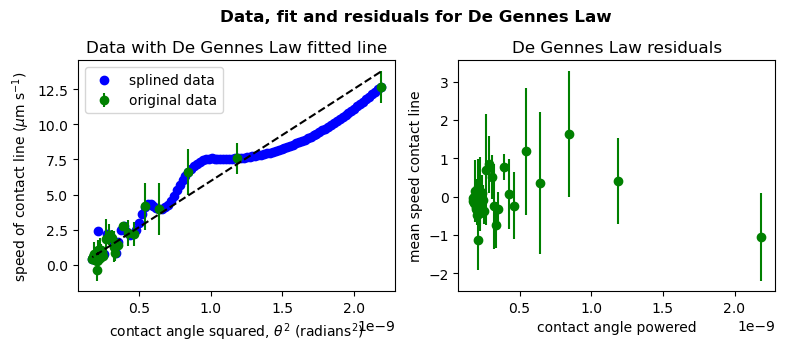

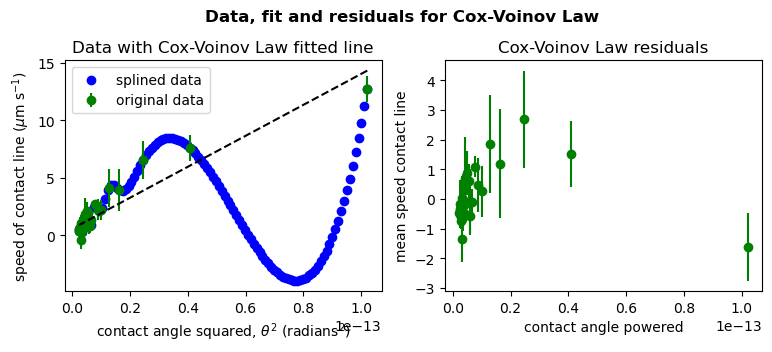

In [18]:
def plot_splined_data(name, contact_angle_powered, means_speed_contact_line, std_speed_contact_line, U_fit):
    # Create splined data using interpolation
    if name == "De Gennes Law":
        spline_interp = interp1d(contact_angle_powered, means_speed_contact_line, kind='quadratic')
    else: 
        spline_interp = interp1d(contact_angle_powered, means_speed_contact_line, kind='cubic')
    
    new_contact_angle = np.linspace(contact_angle_powered[0], contact_angle_powered[-1], 100)
    new_speed_contact_line = spline_interp(new_contact_angle)
    
    # Make plot of the residuals, using the 'errorbar' command 
    plt.rcParams['figure.figsize'] = (9,3)
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Data, fit and residuals for ' + name, y=1.05, fontweight='bold')

    # Plot the data with error bars
    ax1.errorbar(contact_angle_powered, means_speed_contact_line, yerr=std_speed_contact_line, fmt='og', \
                 label='original data')
    ax1.set(xlabel=r'contact angle squared, $\theta^2$ (radians$^2$)')
    ax1.set(ylabel=r'speed of contact line ($\mu$m s$^{-1}$)')
    ax1.set_title('Data with ' + name + ' fitted line')
    
    # Plot splined data on same axis as original data
    ax1.scatter(new_contact_angle, new_speed_contact_line, marker='o', c='blue', label='splined data')

    # Add the fitted line
    ax1.errorbar(contact_angle_powered, U_fit, fmt='--k')
    ax1.legend()

    # On the other plot, plot the residuals
    ax2.errorbar(contact_angle_powered, means_speed_contact_line - U_fit, yerr=std_speed_contact_line, fmt='og')
    ax2.set(xlabel="contact angle powered")
    ax2.set(ylabel="mean speed contact line")
    ax2.set_title(name + ' residuals')
    plt.show()
    plt.close()

plot_splined_data("De Gennes Law", CONTACT_ANGLE_SQUARED, MEANS_SPEED_CONTACT_LINE, STD_SPEED_CONTACT_LINE, DG_U_FIT)
plot_splined_data("Cox-Voinov Law", CONTACT_ANGLE_CUBED, MEANS_SPEED_CONTACT_LINE, STD_SPEED_CONTACT_LINE, CV_U_FIT)


These splined-data plots give much more unacceptable residual plots.